In [1]:
# [CLS]トークンを利用
# 自作のセパレータ
# add_special_tokens

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='022'
    wandb=True
    resume=None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    debug=False  # False
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Sat Jun 11 11:01:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 3.1 MB/s 
CPU times: user 879 ms, sys: 193 ms, total: 1.07 s
Wall time: 25.5 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume=CFG.resume,
                     anonymous=anony)

     |████████████████████████████████| 1.8 MB 5.5 MB/s 
     |████████████████████████████████| 181 kB 43.4 MB/s 
     |████████████████████████████████| 145 kB 54.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)

display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

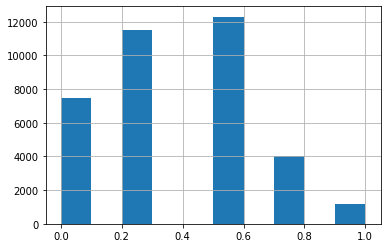

In [11]:
train['score'].hist()

In [12]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [13]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [14]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [16]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
num_added_tokens = tokenizer.add_special_tokens({'additional_special_tokens': ["[s]"]})
print(f"{num_added_tokens} tokens added.")
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1 tokens added.


In [17]:
# 入力テキストを生成

# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text
train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

train['section'] = train['context'].map(lambda s: s[0])
test['section'] = test['context'].map(lambda s: s[0])
train['sectok'] = '[' + train['section'] + ']'
test['sectok'] = '[' + test['section'] + ']'

# anchor, target, context_text をそれぞれ一文ずつとみなす
sep = '[s]'
print(sep)
train['text'] = train['anchor'] + '.' + sep + train['target'] + '.' + sep  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + sep + test['target'] + '.' + sep  + test['context_text'] + '.'
display(train.head())
display(test.head())

[s]


,id,anchor,target,context,score,context_text,fold,section,sectok,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]abatement of pollution.[s]HUMAN N...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]act of abating.[s]HUMAN NECESSITI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]active catalyst.[s]HUMAN NECESSIT...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]eliminating process.[s]HUMAN NECE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]forest region.[s]HUMAN NECESSITIE...


,id,anchor,target,context,context_text,section,sectok,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,G,[G],opc drum.[s]inorganic photoconductor drum.[s]P...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,F,[F],adjust gas flow.[s]altering gas flow.[s]MECHAN...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,B,[B],lower trunnion.[s]lower locating.[s]PERFORMING...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,D,[D],cap component.[s]upper portion.[s]TEXTILES. PA...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,H,[H],neural stimulation.[s]artificial neural networ...


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.model.resize_token_embeddings(len(cfg.tokenizer))
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # (bs, max_len, hidden_size)
        feature = last_hidden_states[:, 0, :]  # [CLS]トークンを利用
        # feature = torch.mean(last_hidden_states, dim=1)  # 全トークンを平均
        # weights = self.attention(last_hidden_states)
        # feature = torch.sum(weights * last_hidden_states, dim=1)  # 全トークンをattentionレイヤで加重平均
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [23]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [24]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1693] Elapsed 0m 1s (remain 33m 10s) Loss: 0.7160(0.7160) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 19s (remain 21m 0s) Loss: 0.6547(0.6474) Grad: 86473.4844  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 2m 38s (remain 19m 35s) Loss: 0.5816(0.6278) Grad: 74320.2344  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 3m 56s (remain 18m 15s) Loss: 0.5459(0.6111) Grad: 37029.1250  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 5m 15s (remain 16m 55s) Loss: 0.6592(0.6014) Grad: 47446.6680  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 6m 33s (remain 15m 35s) Loss: 0.5019(0.5965) Grad: 43034.0273  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 7m 51s (remain 14m 17s) Loss: 0.4695(0.5925) Grad: 16218.9258  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 9m 10s (remain 12m 58s) Loss: 0.5076(0.5875) Grad: 34571.4883  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 10m 28s (remain 11m 40s) Loss: 0.5480(0.5827) Grad: 45860.7148  LR: 0.00001932  
Epoch: [1][900/1693] Elapsed 

Epoch 1 - avg_train_loss: 0.5629  avg_val_loss: 0.5413  time: 1450s
Epoch 1 - Score: 0.8324


EVAL: [586/587] Elapsed 2m 1s (remain 0m 0s) Loss: 0.6861(0.5413) 


Epoch 1 - Save Best Score: 0.8324 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 37m 22s) Loss: 0.5849(0.5849) Grad: 119141.3438  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 23s (remain 21m 51s) Loss: 0.5769(0.5212) Grad: 154802.6250  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 2m 42s (remain 20m 2s) Loss: 0.5093(0.5159) Grad: 49640.5938  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 4m 0s (remain 18m 32s) Loss: 0.4619(0.5168) Grad: 39696.1523  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 5m 18s (remain 17m 7s) Loss: 0.4486(0.5154) Grad: 90608.8750  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 6m 37s (remain 15m 45s) Loss: 0.6051(0.5187) Grad: 224232.4844  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 7m 55s (remain 14m 24s) Loss: 0.5364(0.5191) Grad: 96736.4062  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 9m 14s (remain 13m 4s) Loss: 0.5078(0.5200) Grad: 49402.0664  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 10m 32s (remain 11m 44s) Loss: 0.5378(0.5202) Grad: 70273.5391  LR: 0.00001402  
Epoch: [2][900/1693] E

Epoch 2 - avg_train_loss: 0.5197  avg_val_loss: 0.5431  time: 1454s
Epoch 2 - Score: 0.8449


EVAL: [586/587] Elapsed 2m 1s (remain 0m 0s) Loss: 0.6760(0.5431) 


Epoch 2 - Save Best Score: 0.8449 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 40m 31s) Loss: 0.6294(0.6294) Grad: 74164.5703  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 22s (remain 21m 47s) Loss: 0.4540(0.5157) Grad: 99470.5234  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 2m 41s (remain 20m 1s) Loss: 0.4233(0.5113) Grad: 51518.0039  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 4m 0s (remain 18m 30s) Loss: 0.5454(0.5114) Grad: 262541.2188  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 5m 18s (remain 17m 6s) Loss: 0.4462(0.5130) Grad: 54681.8984  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 6m 37s (remain 15m 44s) Loss: 0.4923(0.5143) Grad: 215688.9062  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 7m 55s (remain 14m 23s) Loss: 0.6078(0.5140) Grad: 311418.7812  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 9m 13s (remain 13m 3s) Loss: 0.4384(0.5116) Grad: 59375.9141  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 10m 32s (remain 11m 44s) Loss: 0.6041(0.5107) Grad: 153122.9062  LR: 0.00000637  
Epoch: [3][900/1693] 

Epoch 3 - avg_train_loss: 0.5079  avg_val_loss: 0.5554  time: 1454s
Epoch 3 - Score: 0.8421


EVAL: [586/587] Elapsed 2m 1s (remain 0m 0s) Loss: 0.6909(0.5554) 
Epoch: [4][0/1693] Elapsed 0m 1s (remain 31m 56s) Loss: 0.5621(0.5621) Grad: 198469.2656  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 21s (remain 21m 29s) Loss: 0.4450(0.5027) Grad: 36033.1289  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 2m 40s (remain 19m 49s) Loss: 0.4970(0.5003) Grad: 63131.8867  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 3m 58s (remain 18m 24s) Loss: 0.5147(0.5007) Grad: 61073.5273  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 5m 17s (remain 17m 2s) Loss: 0.5031(0.5027) Grad: 65524.5195  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 6m 36s (remain 15m 42s) Loss: 0.4855(0.5032) Grad: 119128.4688  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 7m 54s (remain 14m 22s) Loss: 0.4497(0.5033) Grad: 41339.5898  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 9m 12s (remain 13m 2s) Loss: 0.4304(0.5029) Grad: 39564.9414  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 10m 31s (remain 11m 43s) Loss: 0.47

Epoch 4 - avg_train_loss: 0.5014  avg_val_loss: 0.5537  time: 1453s
Epoch 4 - Score: 0.8423


EVAL: [586/587] Elapsed 2m 1s (remain 0m 0s) Loss: 0.6834(0.5537) 


========== fold: 0 result ==========
Score: 0.8449
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1725] Elapsed 0m 1s (remain 39m 44s) Loss: 0.7482(0.7482) Grad: 176317.5469  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 22s (remain 22m 0s) Loss: 0.6038(0.6324) Grad: 86122.3516  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 2m 40s (remain 20m 17s) Loss: 0.7307(0.6175) Grad: inf  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 3m 59s (remain 18m 51s) Loss: 0.5184(0.6074) Grad: 17468.3203  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 5m 17s (remain 17m 28s) Loss: 0.6268(0.5975) Grad: 9403.9766  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 6m 36s (remain 16m 7s) Loss: 0.5613(0.5908) Grad: 18786.2793  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 7m 54s (remain 14m 47s) Loss: 0.5927(0.5869) Grad: 12987.2148  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 9m 13s (remain 13m 27s) Loss: 0.5000(0.5829) Grad: 17984.4863  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 10m 31s (remain 12m 8s) Loss: 0.6404(0.5786) Grad: 16816.1621  LR: 0.00001934  
Epoch: [1][900/1725] Elapsed 11

Epoch 1 - avg_train_loss: 0.5601  avg_val_loss: 0.5553  time: 1473s
Epoch 1 - Score: 0.8070


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.5373(0.5553) 


Epoch 1 - Save Best Score: 0.8070 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 42m 49s) Loss: 0.5144(0.5144) Grad: 82869.6719  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 23s (remain 22m 16s) Loss: 0.4660(0.5207) Grad: 46334.1797  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 2m 41s (remain 20m 26s) Loss: 0.6186(0.5177) Grad: 14655.8096  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 4m 0s (remain 18m 56s) Loss: 0.3607(0.5186) Grad: 18132.1777  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 5m 18s (remain 17m 31s) Loss: 0.4490(0.5207) Grad: 37001.2188  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 6m 37s (remain 16m 10s) Loss: 0.5341(0.5214) Grad: 11274.4463  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 7m 55s (remain 14m 49s) Loss: 0.3892(0.5203) Grad: 69222.2266  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 9m 14s (remain 13m 30s) Loss: 0.5178(0.5194) Grad: 36975.6914  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 10m 33s (remain 12m 10s) Loss: 0.4820(0.5202) Grad: 34380.8633  LR: 0.00001409  
Epoch: [2][900/1725] E

Epoch 2 - avg_train_loss: 0.5177  avg_val_loss: 0.5585  time: 1473s
Epoch 2 - Score: 0.8216


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.4981(0.5585) 


Epoch 2 - Save Best Score: 0.8216 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 41m 10s) Loss: 0.5267(0.5267) Grad: 129622.5156  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 23s (remain 22m 21s) Loss: 0.6207(0.5068) Grad: 7104.1587  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 2m 42s (remain 20m 28s) Loss: 0.5445(0.4950) Grad: 19774.3574  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 4m 0s (remain 18m 57s) Loss: 0.5373(0.4995) Grad: 25682.4648  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 5m 19s (remain 17m 33s) Loss: 0.4926(0.4991) Grad: 11815.7910  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 6m 37s (remain 16m 11s) Loss: 0.5672(0.5014) Grad: 49458.5156  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 7m 56s (remain 14m 50s) Loss: 0.4348(0.4989) Grad: 16234.8740  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 9m 14s (remain 13m 30s) Loss: 0.3627(0.4996) Grad: 4053.2319  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 10m 33s (remain 12m 10s) Loss: 0.5499(0.5011) Grad: 9625.1807  LR: 0.00000644  
Epoch: [3][900/1725] Ela

Epoch 3 - avg_train_loss: 0.5021  avg_val_loss: 0.5614  time: 1473s
Epoch 3 - Score: 0.8250


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.5002(0.5614) 


Epoch 3 - Save Best Score: 0.8250 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 41m 4s) Loss: 0.5315(0.5315) Grad: inf  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 23s (remain 22m 15s) Loss: 0.4111(0.5003) Grad: 22657.0996  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 2m 41s (remain 20m 26s) Loss: 0.4935(0.4986) Grad: 64960.1836  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 4m 0s (remain 18m 56s) Loss: 0.4359(0.4984) Grad: 15279.8359  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 5m 18s (remain 17m 31s) Loss: 0.5566(0.5007) Grad: 11981.3799  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 6m 37s (remain 16m 9s) Loss: 0.4294(0.4990) Grad: 10135.7666  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 7m 55s (remain 14m 49s) Loss: 0.5130(0.4964) Grad: 21898.3633  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 9m 13s (remain 13m 29s) Loss: 0.4940(0.4957) Grad: 14465.5449  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 10m 32s (remain 12m 9s) Loss: 0.5700(0.4958) Grad: 82531.5547  LR: 0.00000088  
Epoch: [4][900/1725] Elapsed 11m

Epoch 4 - avg_train_loss: 0.4940  avg_val_loss: 0.5678  time: 1472s
Epoch 4 - Score: 0.8249


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.5006(0.5678) 


========== fold: 1 result ==========
Score: 0.8250
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1741] Elapsed 0m 1s (remain 42m 49s) Loss: 0.6996(0.6996) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 21s (remain 22m 2s) Loss: 0.6445(0.6460) Grad: 47920.8203  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 2m 40s (remain 20m 26s) Loss: 0.6147(0.6215) Grad: 32780.0469  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 3m 58s (remain 19m 0s) Loss: 0.5819(0.6065) Grad: 51094.5039  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 5m 17s (remain 17m 39s) Loss: 0.6919(0.5988) Grad: 111794.4141  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 6m 35s (remain 16m 18s) Loss: 0.5440(0.5887) Grad: 25100.7832  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 7m 53s (remain 14m 59s) Loss: 0.5882(0.5837) Grad: 46631.6055  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 9m 12s (remain 13m 39s) Loss: 0.5385(0.5818) Grad: 37992.8789  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 10m 30s (remain 12m 20s) Loss: 0.5573(0.5775) Grad: 45899.4805  LR: 0.00001935  
Epoch: [1][900/1741] Elapsed 

Epoch 1 - avg_train_loss: 0.5620  avg_val_loss: 0.5389  time: 1481s
Epoch 1 - Score: 0.8252
Epoch 1 - Save Best Score: 0.8252 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 41m 29s) Loss: 0.5465(0.5465) Grad: 74765.0859  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 23s (remain 22m 32s) Loss: 0.4368(0.5188) Grad: 92759.7734  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 2m 41s (remain 20m 39s) Loss: 0.5285(0.5252) Grad: 124044.0703  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 4m 0s (remain 19m 9s) Loss: 0.4998(0.5219) Grad: 59945.4531  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 5m 18s (remain 17m 45s) Loss: 0.4559(0.5223) Grad: 97872.1016  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 6m 37s (remain 16m 23s) Loss: 0.3906(0.5223) Grad: 124214.3203  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 7m 55s (remain 15m 2s) Loss: 0.5654(0.5229) Grad: 114674.0391  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 9m 14s (remain 13m 42s) Loss: 0.6371(0.5217) Grad: 793534.4375  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 10m 33s (remain 12m 23s) Loss: 0.6210(0.5215) Grad: 129446.9609  LR: 0.00001412  
Epoch: [2][900/1741

Epoch 2 - avg_train_loss: 0.5222  avg_val_loss: 0.5384  time: 1483s
Epoch 2 - Score: 0.8439
Epoch 2 - Save Best Score: 0.8439 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 36m 49s) Loss: 0.4970(0.4970) Grad: 64257.8906  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 23s (remain 22m 33s) Loss: 0.5046(0.5053) Grad: 58917.2461  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 2m 41s (remain 20m 40s) Loss: 0.4315(0.5097) Grad: 92947.1406  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 4m 0s (remain 19m 9s) Loss: 0.4793(0.5126) Grad: 109980.2812  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 5m 18s (remain 17m 45s) Loss: 0.5064(0.5101) Grad: 122530.8906  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 6m 37s (remain 16m 23s) Loss: 0.5307(0.5117) Grad: 37896.9219  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 7m 55s (remain 15m 2s) Loss: 0.5708(0.5115) Grad: 55445.6406  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 9m 14s (remain 13m 42s) Loss: 0.5874(0.5111) Grad: 29789.5449  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 10m 32s (remain 12m 22s) Loss: 0.4873(0.5108) Grad: 56554.6797  LR: 0.00000647  
Epoch: [3][900/1741] E

Epoch 3 - avg_train_loss: 0.5104  avg_val_loss: 0.5487  time: 1482s
Epoch 3 - Score: 0.8397


EVAL: [538/539] Elapsed 1m 51s (remain 0m 0s) Loss: 0.3488(0.5487) 
Epoch: [4][0/1741] Elapsed 0m 1s (remain 34m 38s) Loss: 0.4560(0.4560) Grad: 35058.4453  LR: 0.00000293  
Epoch: [4][100/1741] Elapsed 1m 21s (remain 22m 11s) Loss: 0.4670(0.4975) Grad: 50618.8672  LR: 0.00000262  
Epoch: [4][200/1741] Elapsed 2m 40s (remain 20m 29s) Loss: 0.5401(0.5034) Grad: 57915.3320  LR: 0.00000232  
Epoch: [4][300/1741] Elapsed 3m 58s (remain 19m 2s) Loss: 0.5840(0.5031) Grad: 147063.5781  LR: 0.00000204  
Epoch: [4][400/1741] Elapsed 5m 17s (remain 17m 40s) Loss: 0.4638(0.5018) Grad: 45635.5352  LR: 0.00000177  
Epoch: [4][500/1741] Elapsed 6m 35s (remain 16m 19s) Loss: 0.4877(0.5042) Grad: 60798.2734  LR: 0.00000153  
Epoch: [4][600/1741] Elapsed 7m 54s (remain 14m 59s) Loss: 0.5228(0.5042) Grad: 28369.0117  LR: 0.00000130  
Epoch: [4][700/1741] Elapsed 9m 12s (remain 13m 39s) Loss: 0.5713(0.5037) Grad: 107093.4375  LR: 0.00000108  
Epoch: [4][800/1741] Elapsed 10m 31s (remain 12m 20s) Loss: 0.

Epoch 4 - avg_train_loss: 0.5037  avg_val_loss: 0.5520  time: 1481s
Epoch 4 - Score: 0.8396


EVAL: [538/539] Elapsed 1m 51s (remain 0m 0s) Loss: 0.3472(0.5520) 


========== fold: 2 result ==========
Score: 0.8439
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1678] Elapsed 0m 1s (remain 49m 27s) Loss: 0.6480(0.6480) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 22s (remain 21m 33s) Loss: 0.6493(0.6442) Grad: 118366.0703  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 2m 41s (remain 19m 45s) Loss: 0.6041(0.6243) Grad: 78772.6094  LR: 0.00001996  
Epoch: [1][300/1678] Elapsed 3m 59s (remain 18m 16s) Loss: 0.5158(0.6118) Grad: 53266.1953  LR: 0.00001990  
Epoch: [1][400/1678] Elapsed 5m 18s (remain 16m 53s) Loss: 0.4732(0.6021) Grad: 59963.0781  LR: 0.00001982  
Epoch: [1][500/1678] Elapsed 6m 36s (remain 15m 32s) Loss: 0.5214(0.5948) Grad: 61850.4688  LR: 0.00001973  
Epoch: [1][600/1678] Elapsed 7m 55s (remain 14m 11s) Loss: 0.6487(0.5882) Grad: 111491.9844  LR: 0.00001961  
Epoch: [1][700/1678] Elapsed 9m 13s (remain 12m 51s) Loss: 0.5505(0.5837) Grad: 110924.3906  LR: 0.00001947  
Epoch: [1][800/1678] Elapsed 10m 32s (remain 11m 32s) Loss: 0.5597(0.5818) Grad: 76250.6953  LR: 0.00001931  
Epoch: [1][900/1678] Elap

Epoch 1 - avg_train_loss: 0.5670  avg_val_loss: 0.5663  time: 1446s
Epoch 1 - Score: 0.7926
Epoch 1 - Save Best Score: 0.7926 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 44m 28s) Loss: 0.5299(0.5299) Grad: 166079.7344  LR: 0.00001707  
Epoch: [2][100/1678] Elapsed 1m 23s (remain 21m 40s) Loss: 0.5312(0.5309) Grad: 123608.9922  LR: 0.00001673  
Epoch: [2][200/1678] Elapsed 2m 41s (remain 19m 49s) Loss: 0.4027(0.5347) Grad: 107020.7812  LR: 0.00001638  
Epoch: [2][300/1678] Elapsed 4m 0s (remain 18m 19s) Loss: 0.5966(0.5339) Grad: 86159.7500  LR: 0.00001601  
Epoch: [2][400/1678] Elapsed 5m 18s (remain 16m 55s) Loss: 0.5763(0.5314) Grad: 101501.4062  LR: 0.00001563  
Epoch: [2][500/1678] Elapsed 6m 37s (remain 15m 33s) Loss: 0.4871(0.5304) Grad: 62519.8945  LR: 0.00001523  
Epoch: [2][600/1678] Elapsed 7m 55s (remain 14m 12s) Loss: 0.4234(0.5315) Grad: 87028.9688  LR: 0.00001483  
Epoch: [2][700/1678] Elapsed 9m 14s (remain 12m 52s) Loss: 0.4765(0.5303) Grad: 198203.7031  LR: 0.00001442  
Epoch: [2][800/1678] Elapsed 10m 33s (remain 11m 33s) Loss: 0.5860(0.5293) Grad: 95002.4766  LR: 0.00001399  
Epoch: [2][900/16

Epoch 2 - avg_train_loss: 0.5230  avg_val_loss: 0.5586  time: 1446s
Epoch 2 - Score: 0.8112
Epoch 2 - Save Best Score: 0.8112 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 42m 14s) Loss: 0.7191(0.7191) Grad: 236642.8906  LR: 0.00001000  
Epoch: [3][100/1678] Elapsed 1m 22s (remain 21m 30s) Loss: 0.6446(0.5077) Grad: 113676.5469  LR: 0.00000953  
Epoch: [3][200/1678] Elapsed 2m 41s (remain 19m 46s) Loss: 0.4429(0.5096) Grad: 102550.5859  LR: 0.00000906  
Epoch: [3][300/1678] Elapsed 4m 0s (remain 18m 19s) Loss: 0.4647(0.5107) Grad: 72643.5469  LR: 0.00000860  
Epoch: [3][400/1678] Elapsed 5m 18s (remain 16m 54s) Loss: 0.5701(0.5088) Grad: 101288.1406  LR: 0.00000813  
Epoch: [3][500/1678] Elapsed 6m 37s (remain 15m 32s) Loss: 0.5465(0.5092) Grad: 91916.1328  LR: 0.00000768  
Epoch: [3][600/1678] Elapsed 7m 55s (remain 14m 12s) Loss: 0.3917(0.5095) Grad: 118888.9766  LR: 0.00000722  
Epoch: [3][700/1678] Elapsed 9m 13s (remain 12m 52s) Loss: 0.5135(0.5098) Grad: 87731.6016  LR: 0.00000678  
Epoch: [3][800/1678] Elapsed 10m 32s (remain 11m 32s) Loss: 0.4645(0.5117) Grad: 67736.5469  LR: 0.00000634  
Epoch: [3][900/16

Epoch 3 - avg_train_loss: 0.5106  avg_val_loss: 0.5606  time: 1445s
Epoch 3 - Score: 0.8143
Epoch 3 - Save Best Score: 0.8143 Model


Epoch: [4][0/1678] Elapsed 0m 1s (remain 33m 6s) Loss: 0.4821(0.4821) Grad: 47540.5312  LR: 0.00000293  
Epoch: [4][100/1678] Elapsed 1m 23s (remain 21m 41s) Loss: 0.3778(0.5042) Grad: 42306.5898  LR: 0.00000260  
Epoch: [4][200/1678] Elapsed 2m 42s (remain 19m 51s) Loss: 0.5623(0.5014) Grad: 54713.9258  LR: 0.00000230  
Epoch: [4][300/1678] Elapsed 4m 0s (remain 18m 20s) Loss: 0.6100(0.5042) Grad: 63295.0664  LR: 0.00000201  
Epoch: [4][400/1678] Elapsed 5m 19s (remain 16m 56s) Loss: 0.5470(0.5050) Grad: 135929.7500  LR: 0.00000173  
Epoch: [4][500/1678] Elapsed 6m 37s (remain 15m 34s) Loss: 0.4364(0.5029) Grad: 102642.5156  LR: 0.00000148  
Epoch: [4][600/1678] Elapsed 7m 56s (remain 14m 13s) Loss: 0.5202(0.5033) Grad: 111373.2891  LR: 0.00000124  
Epoch: [4][700/1678] Elapsed 9m 14s (remain 12m 52s) Loss: 0.4852(0.5023) Grad: 133641.7344  LR: 0.00000103  
Epoch: [4][800/1678] Elapsed 10m 33s (remain 11m 33s) Loss: 0.5537(0.5032) Grad: 75063.7578  LR: 0.00000083  
Epoch: [4][900/1678

Epoch 4 - avg_train_loss: 0.5032  avg_val_loss: 0.5623  time: 1447s
Epoch 4 - Score: 0.8136
========== fold: 3 result ==========
Score: 0.8143
========== CV ==========
Score: 0.8317


[fold0] avg_train_loss,█▃▂▁
[fold0] avg_val_loss,▁▂█▇
[fold0] epoch,▁▃▆█
[fold0] loss,█▄▅█▆▆▆▃▄▆▅▄▁▅▅▃▅▆▇▄▂▇▆▄▄▄▅▅▅▁▅▂▃▂▆▆▃▄▂▇
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁█▆▇
[fold1] avg_train_loss,█▄▂▁
[fold1] avg_val_loss,▁▃▄█
[fold1] epoch,▁▃▆█
[fold1] loss,██▇▃▆▆▅▄▆▄▇▃▅▅▆▄▃▆▆▃▂▃▃▄▆▄▁▇▃▅▇▃▆▄▄▃▆▄▆▄
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [25]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.23k/2.23k [00:01<00:00, 1.84kB/s]
Upload successful: train.log (2KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:00<00:00, 15.8kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:01<00:00, 1.71MB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:01<00:00, 1.96kB/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:22<00:00, 76.6MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:22<00:00, 76.4MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [00:21<00:00, 81.0MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upl